# Decision Tree 

#### Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom imports
import utils
import model_utils

# Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introdcution](#intro)
2. [Data Loading](#dl)<br>
    2.1 [Preprocessing](#pp)<br>
3. [Modelling](#modelling)<br>
    3.1 [Baseline Model](#base)<br>
    3.2 [Upsampling with SMOTE](#smote)<br>
4. [Model Optimisation](#optimisation)<br>
    4.1 [Hyperparameter Optimisation](#param_opt)<br>
    4.2 [Hyperparameter Optimisation with Grid Search](#gridsearch)<br>
    4.2.1 [Saving the model](#save)<br>
    4.2.2 [Loading the model](#load)<br>
5. [Remarks on Decision Trees](#conc)<br>

---

<a id='intro'></a>

# Introduction

A decision tree classifier is a supervised learning algorithm that, as we have seen, can be used for regression tasks. It can, however, also be used for classification. The algorithm works by constructing a tree of decision nodes, where each node represents a decision about which feature to split on, and each branch represents the possible outcomes of that decision. The tree is constructed by recursively applying the splitting criterion to the training data, starting at the root node and working down to the leaves. At each node, the algorithm selects the feature that maximizes the information gain, and splits the data accordingly. The leaves of the tree represent the predicted class labels for the data.

The decision tree classifier is a powerful tool for both classification and regression tasks, and can be used on a variety of data sets. The algorithm is easy to interpret and can be used to make predictions on new data. Most importantly, it can be used when a classification is not linearly separable, which we have seen so far to be the case. The structure of the notebook will be similar to those prior to it; we will begin by loading our data and creating a baseline model, upon which we will then build upon.

---
<a id='dl'></a>
## Data Loading

In [2]:
df = utils.LoadDf()

In [3]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


<a id='pp'></a>
### Preprocessing

This will follow the same process as in previous models, however we will not have to convert the numeric columns as Decision Trees are insensitive to outliers in the data.

In [4]:
df = utils.BasicCategoricalPreprocessing(df)

In [5]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.10,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.00,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0
2,1992,2,0.25,A,40.775000,-74.854160,6.385714,1.585714,67.185714,1.394286,...,0,0,0,0,0,0,0,0,0,0
3,1992,3,1.91,B,31.018500,-83.297300,14.457143,11.828571,78.957143,4.685714,...,0,0,0,0,0,0,0,0,0,0
4,1992,3,2.00,B,30.728900,-87.238100,14.428571,10.985714,79.971429,0.188571,...,0,0,0,0,0,0,0,0,0,0


---
<a id='modelling'></a>
## Modelling

In order to establish a baseline performance metric for future models, we need to build a baseline model. 

<a id='base'></a>
### Baseline Model

In [6]:
from sklearn.model_selection import train_test_split

X, y = model_utils.GenerateXy(df)

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [7]:
from sklearn.tree import DecisionTreeClassifier

base_DT_model = DecisionTreeClassifier(random_state=1)
base_DT_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [8]:
print(f"The train classification accuracy is:  {base_DT_model.score(X_train,y_train)}")
print(f"The test classification accuracy is:  {base_DT_model.score(X_test,y_test)}")

The train classification accuracy is:  0.9997477613822676
The test classification accuracy is:  0.3435345552379351


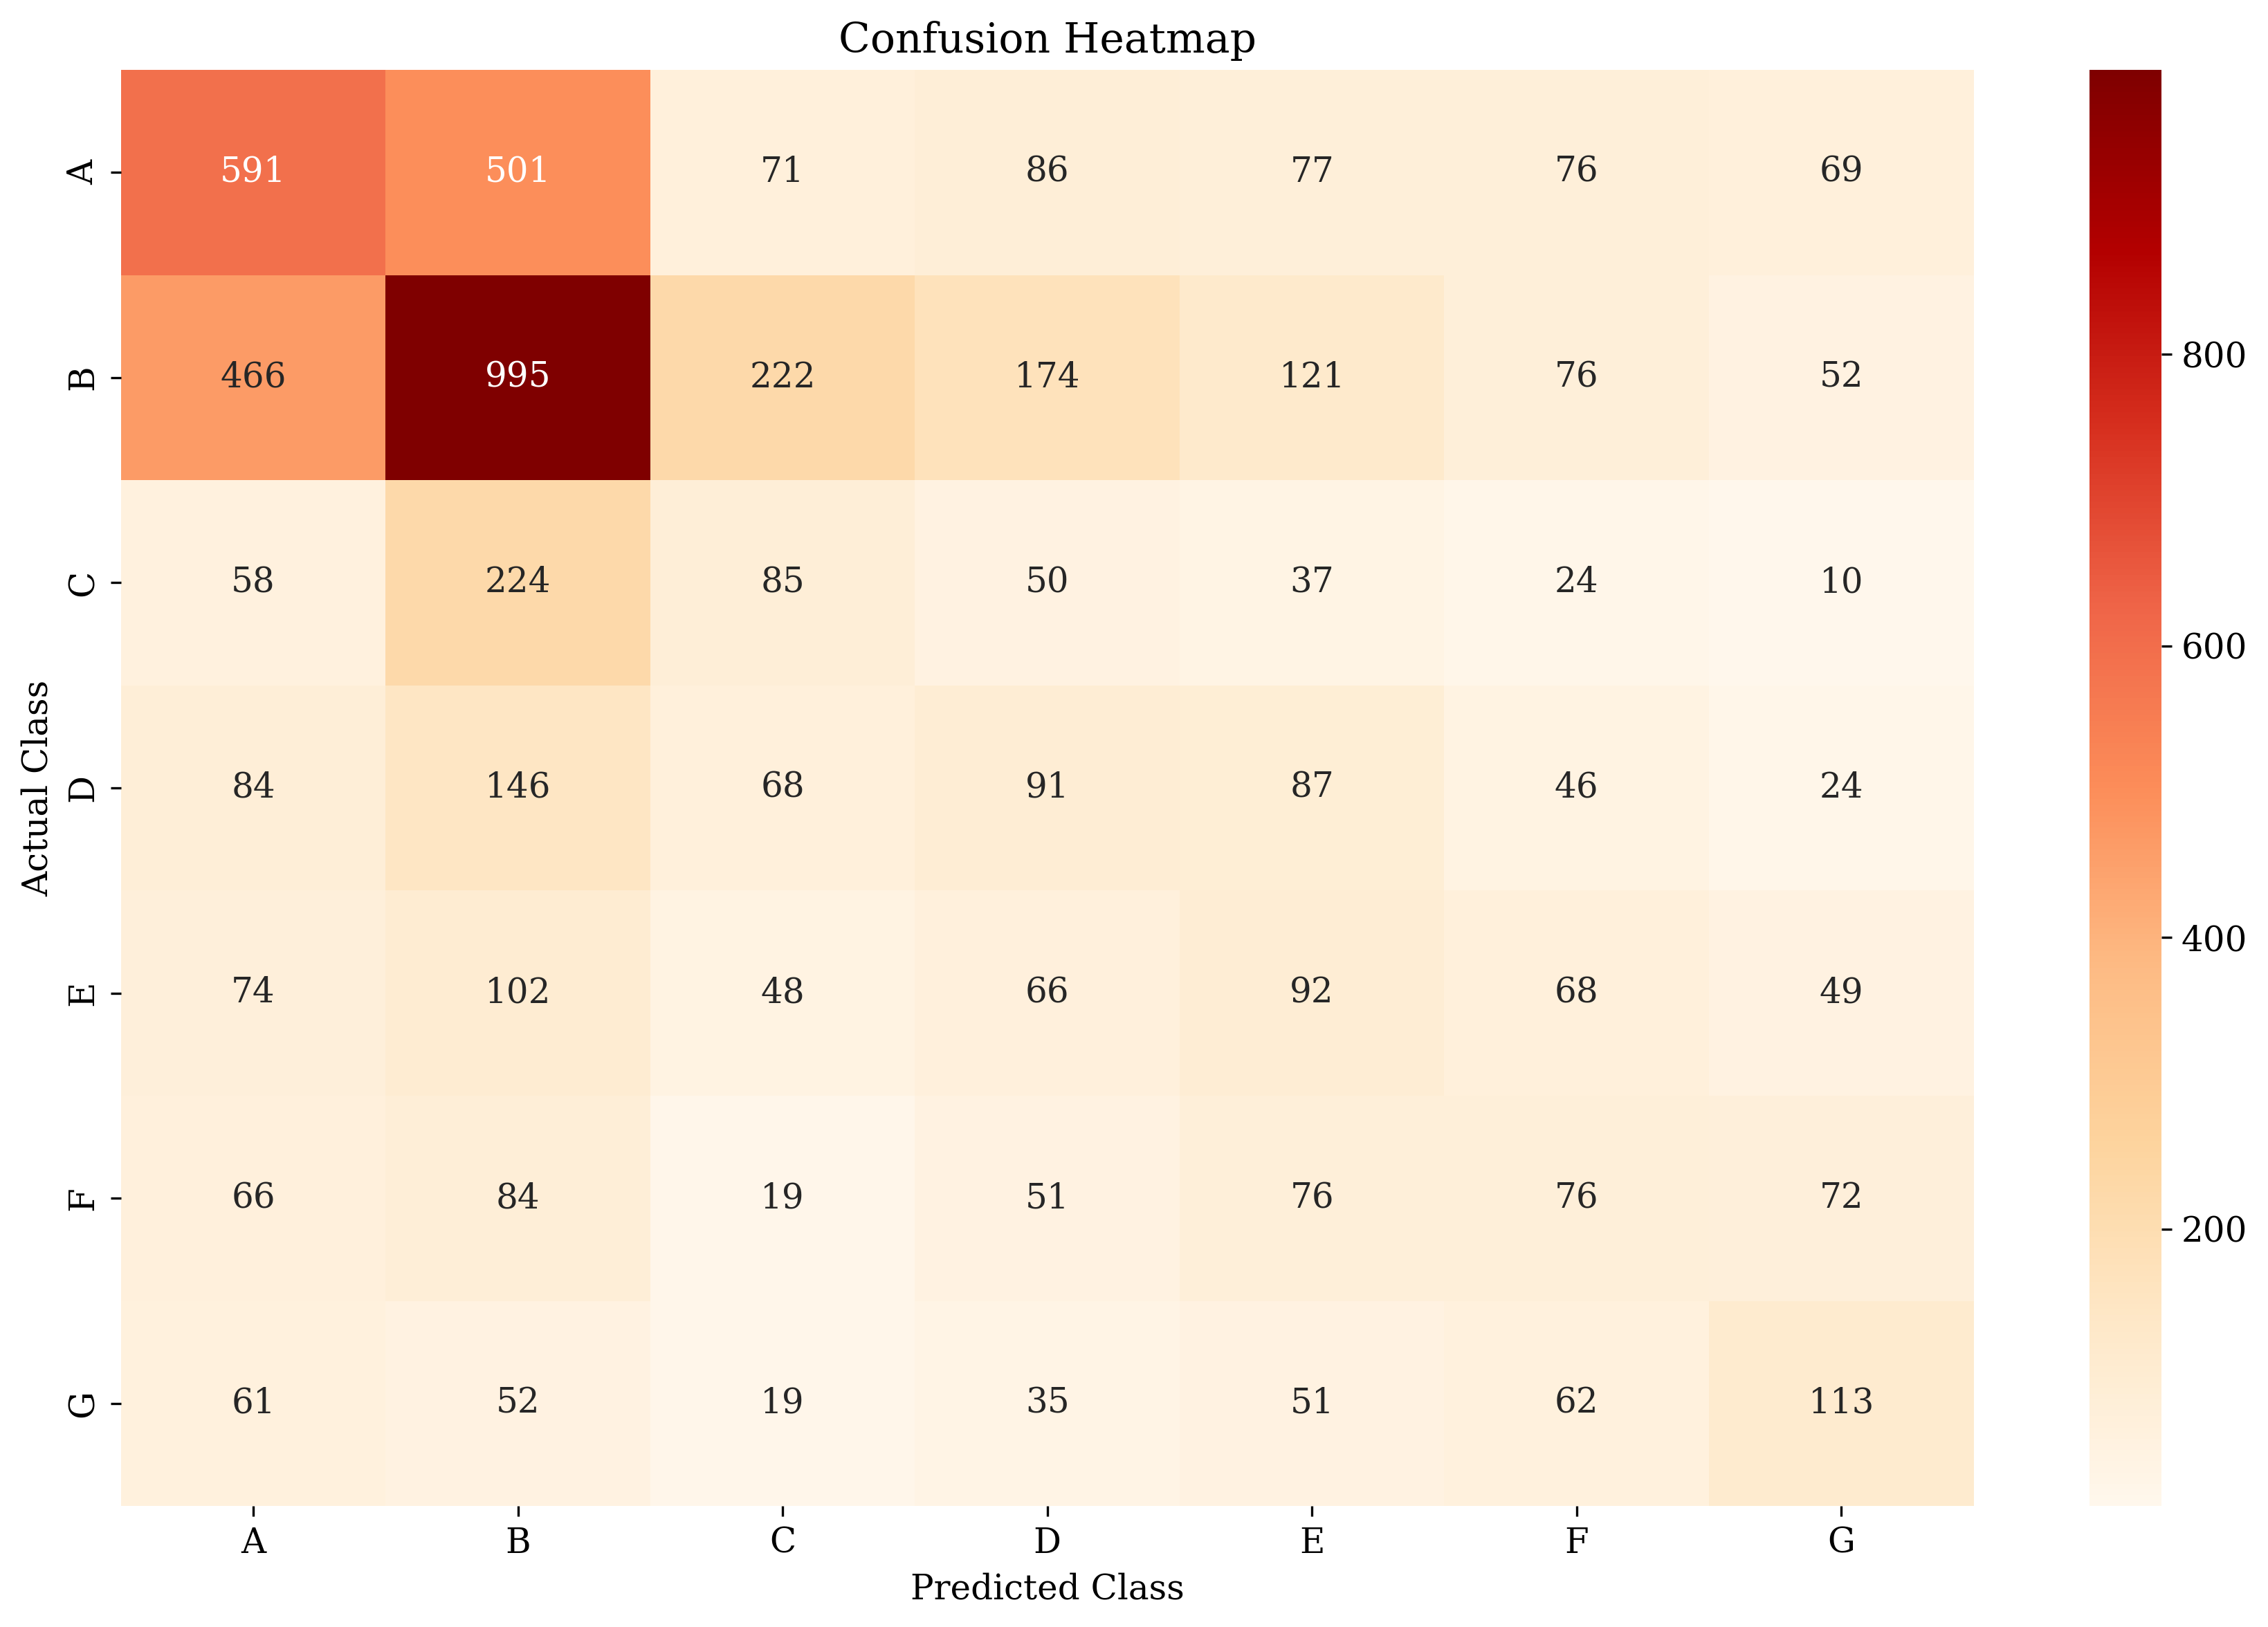

              precision    recall  f1-score   support

           A       0.42      0.40      0.41      1471
           B       0.47      0.47      0.47      2106
           C       0.16      0.17      0.17       488
           D       0.16      0.17      0.17       546
           E       0.17      0.18      0.18       499
           F       0.18      0.17      0.17       444
           G       0.29      0.29      0.29       393

    accuracy                           0.34      5947
   macro avg       0.27      0.27      0.27      5947
weighted avg       0.35      0.34      0.35      5947



In [9]:
model_utils.PlotConfusionMatrix(base_DT_model, X_test, y_test)

If we compare this to the baseline logistic regression that we created in the previous notebook, we see that overall the model performed worse. That being said, the precision and recall scores for classes C through F improved. The model is therefore better at predicting these intermediate fire categories than the previous model.

We also need to be aware of the imbalances in this data set, which can be seen below:

In [10]:
utils.count_percentage_df(y_train).sort_index()

,Count,Percentage of Total
A,5884,0.247362
B,8423,0.354101
C,1953,0.082104
D,2182,0.091731
E,1995,0.083869
F,1778,0.074747
G,1572,0.066087


Given the uneven distribution of `FIRE_SIZE_CLASS`, we see that the model is actually worse than a dummy model that always predicts class B. There are obviously improvements to be made, such as hyperparameter optimisation, but before this we will increase the number of samples using SMOTE, a method that we have used previously. As we have mentioned, the purpose of SMOTE is to increase the underrepresented classes within the data such that a model may improve the predictions it makes for these.

<a id='smote'></a>
### Upsampling with SMOTE

In [11]:
from imblearn.over_sampling import SMOTE

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [12]:
utils.count_percentage_df(y_train_sm)

,Count,Percentage of Total
B,8423,0.142857
A,8423,0.142857
D,8423,0.142857
E,8423,0.142857
G,8423,0.142857
C,8423,0.142857
F,8423,0.142857


In [13]:
DT_model = DecisionTreeClassifier(random_state=1)
DT_model.fit(X_train_sm, y_train_sm)

print(f'The SMOTE model achieved {DT_model.score(X_test, y_test):.4f} accuracy.')

The SMOTE model achieved 0.3212 accuracy.


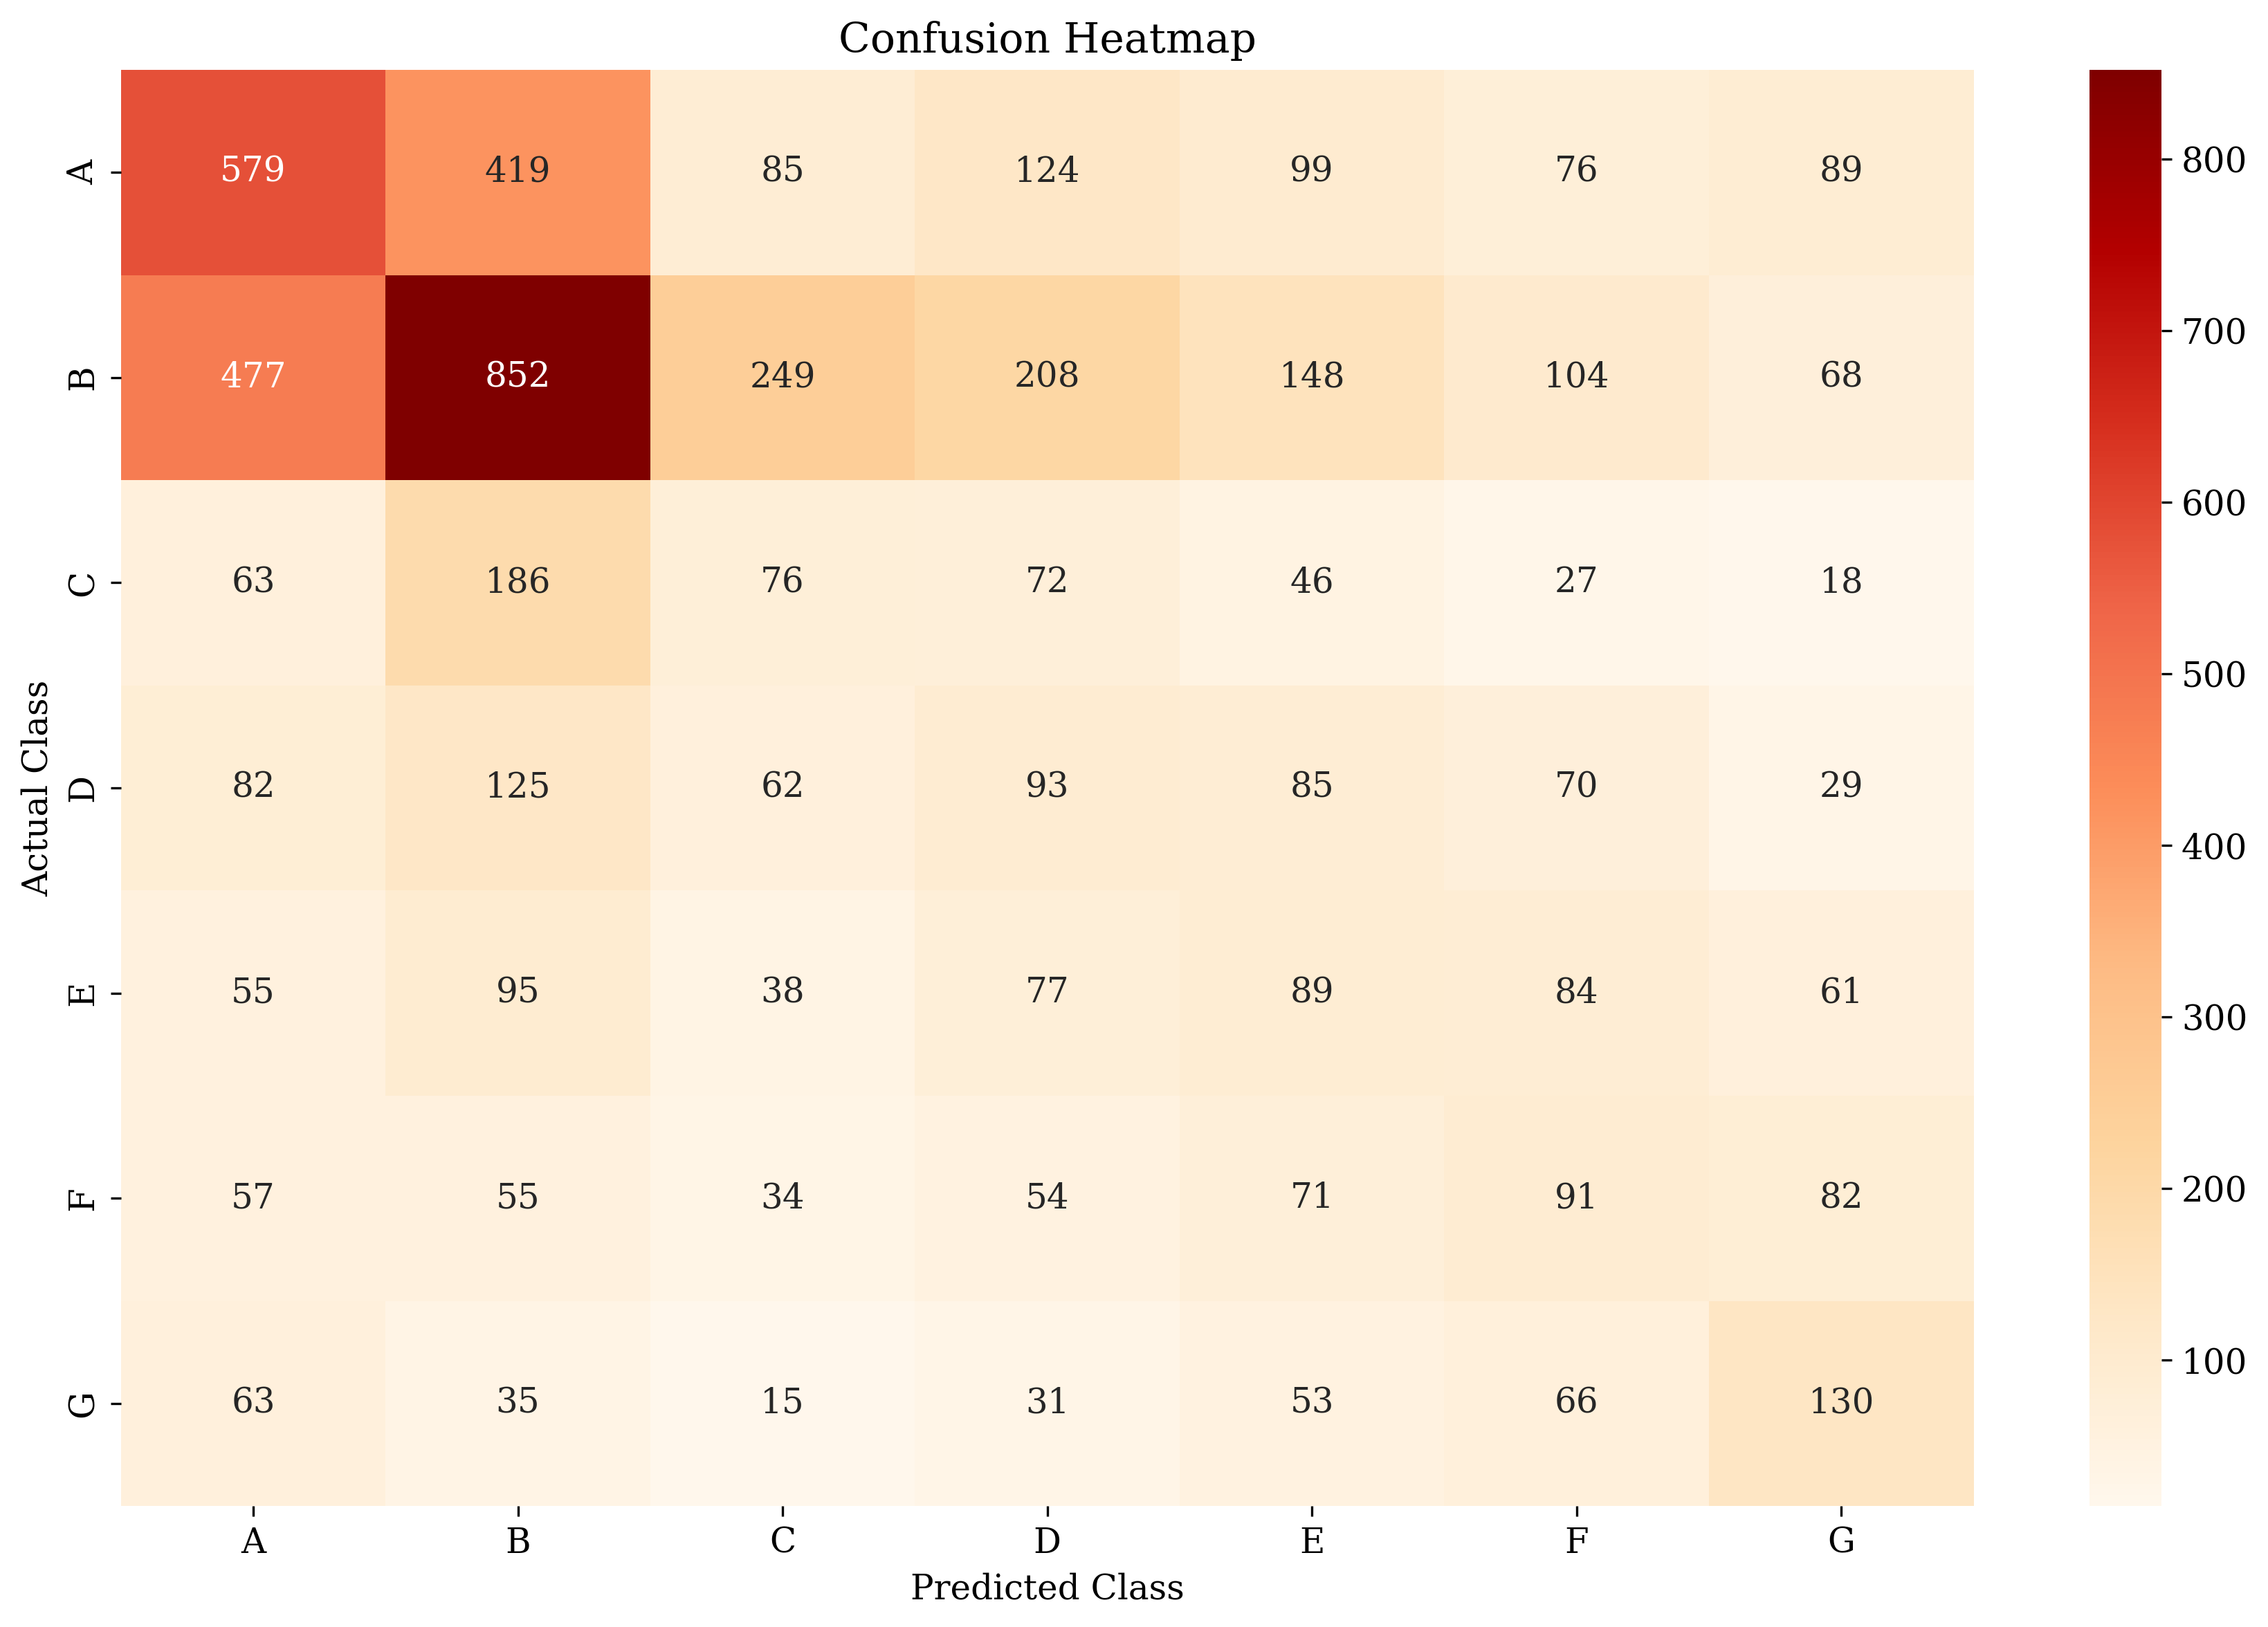

              precision    recall  f1-score   support

           A       0.42      0.39      0.41      1471
           B       0.48      0.40      0.44      2106
           C       0.14      0.16      0.15       488
           D       0.14      0.17      0.15       546
           E       0.15      0.18      0.16       499
           F       0.18      0.20      0.19       444
           G       0.27      0.33      0.30       393

    accuracy                           0.32      5947
   macro avg       0.25      0.26      0.26      5947
weighted avg       0.34      0.32      0.33      5947



In [14]:
model_utils.PlotConfusionMatrix(DT_model, X_test, y_test)

Unfortunately the model accuracy has now decreased even more than previously - SMOTE was unable to help the model classify the minority classes and actually reduced the  f1 scores for many of the classes. Considering that SMOTE is unable to create useful synthetic observations, we will no longer be using SMOTE to build model. Hopefully, however, hyperparameter optimisation will improve the accuracy of the model.

---
<a id='optimisation'></a>
## Model Optimisation

<a id='param_opt'></a>
### Hyperparameter Optimisation

From the results above we realise that while the train scores were very high, the test scores were very low. This is indicative of the decision tree overfitting to the data - a problem which Decision Trees tend to be prone to if not given the correct hyperparameters. We will therefore try to improve on the hyperparameters starting with depth, which prevents the tree from splitting on too many features.

In [15]:
# Create train, validation and test set
X_rem, X_test, y_rem, y_test = \
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

X_train, X_validation, y_train, y_validation = \
train_test_split(X_rem, y_rem, test_size=0.2, stratify=y_rem, random_state=1)

In [16]:
depths = list(range(1, 51, 1))
train_accuracies = []
validation_accuracies = []

for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    # Create model
    DT_model = DecisionTreeClassifier(max_depth=depth)
    DT_model.fit(X_train, y_train)
    
    # Append scores
    train_accuracies.append(DT_model.score(X_train, y_train))
    validation_accuracies.append(DT_model.score(X_validation, y_validation))

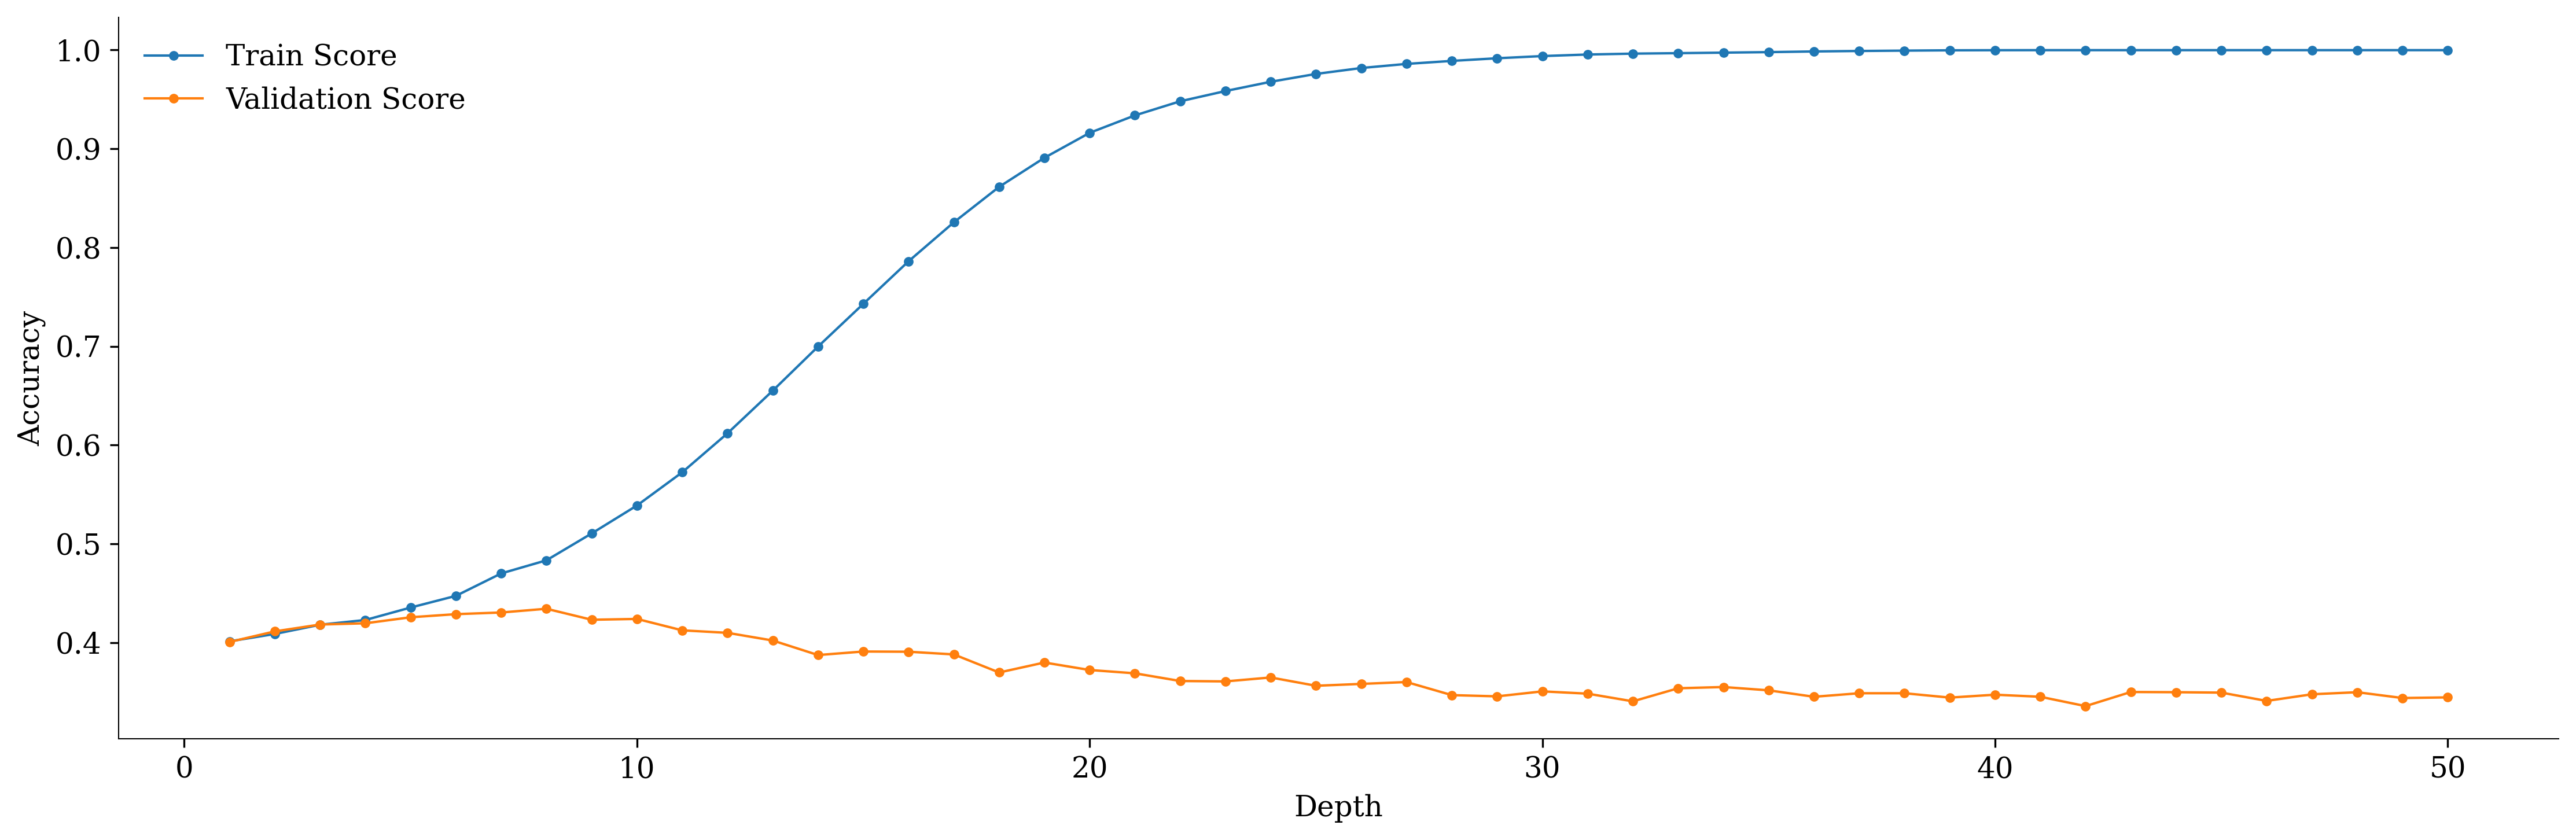

In [17]:
model_utils.PlotTrainTest(depths, 'Depth', train_accuracies, validation_accuracies, validation=True)

We are able to learn a few things from the model above. The first is that as the depth increases, the model overfits to the training data. This is understandable considering that the model is increasing the number of decision boundaries to the point that all of the data points can be separated. A corollary is therefore that as the depth increases, the validation accuracy increases. There is a depth, however, at which the validation accuracy is maximised, and it should be at that depth that we build our subsequent models. 

In [18]:
best_d = depths[np.argmax(validation_accuracies)]
print(f'The depth with the highest validation accuracy is: {best_d}')

The depth with the highest validation accuracy is: 8


In [19]:
DT_model = DecisionTreeClassifier(max_depth=best_d)
DT_model.fit(X_train, y_train)

DT_model.score(X_test, y_test)

print(f'The decision tree model with a depth of {best_d} achieved {DT_model.score(X_test, y_test):.4f} accuracy.')

The decision tree model with a depth of 8 achieved 0.4242 accuracy.


We see that this is a big improvement on the model that we created earlier. Let us see how this translates onto the confusion matrix.

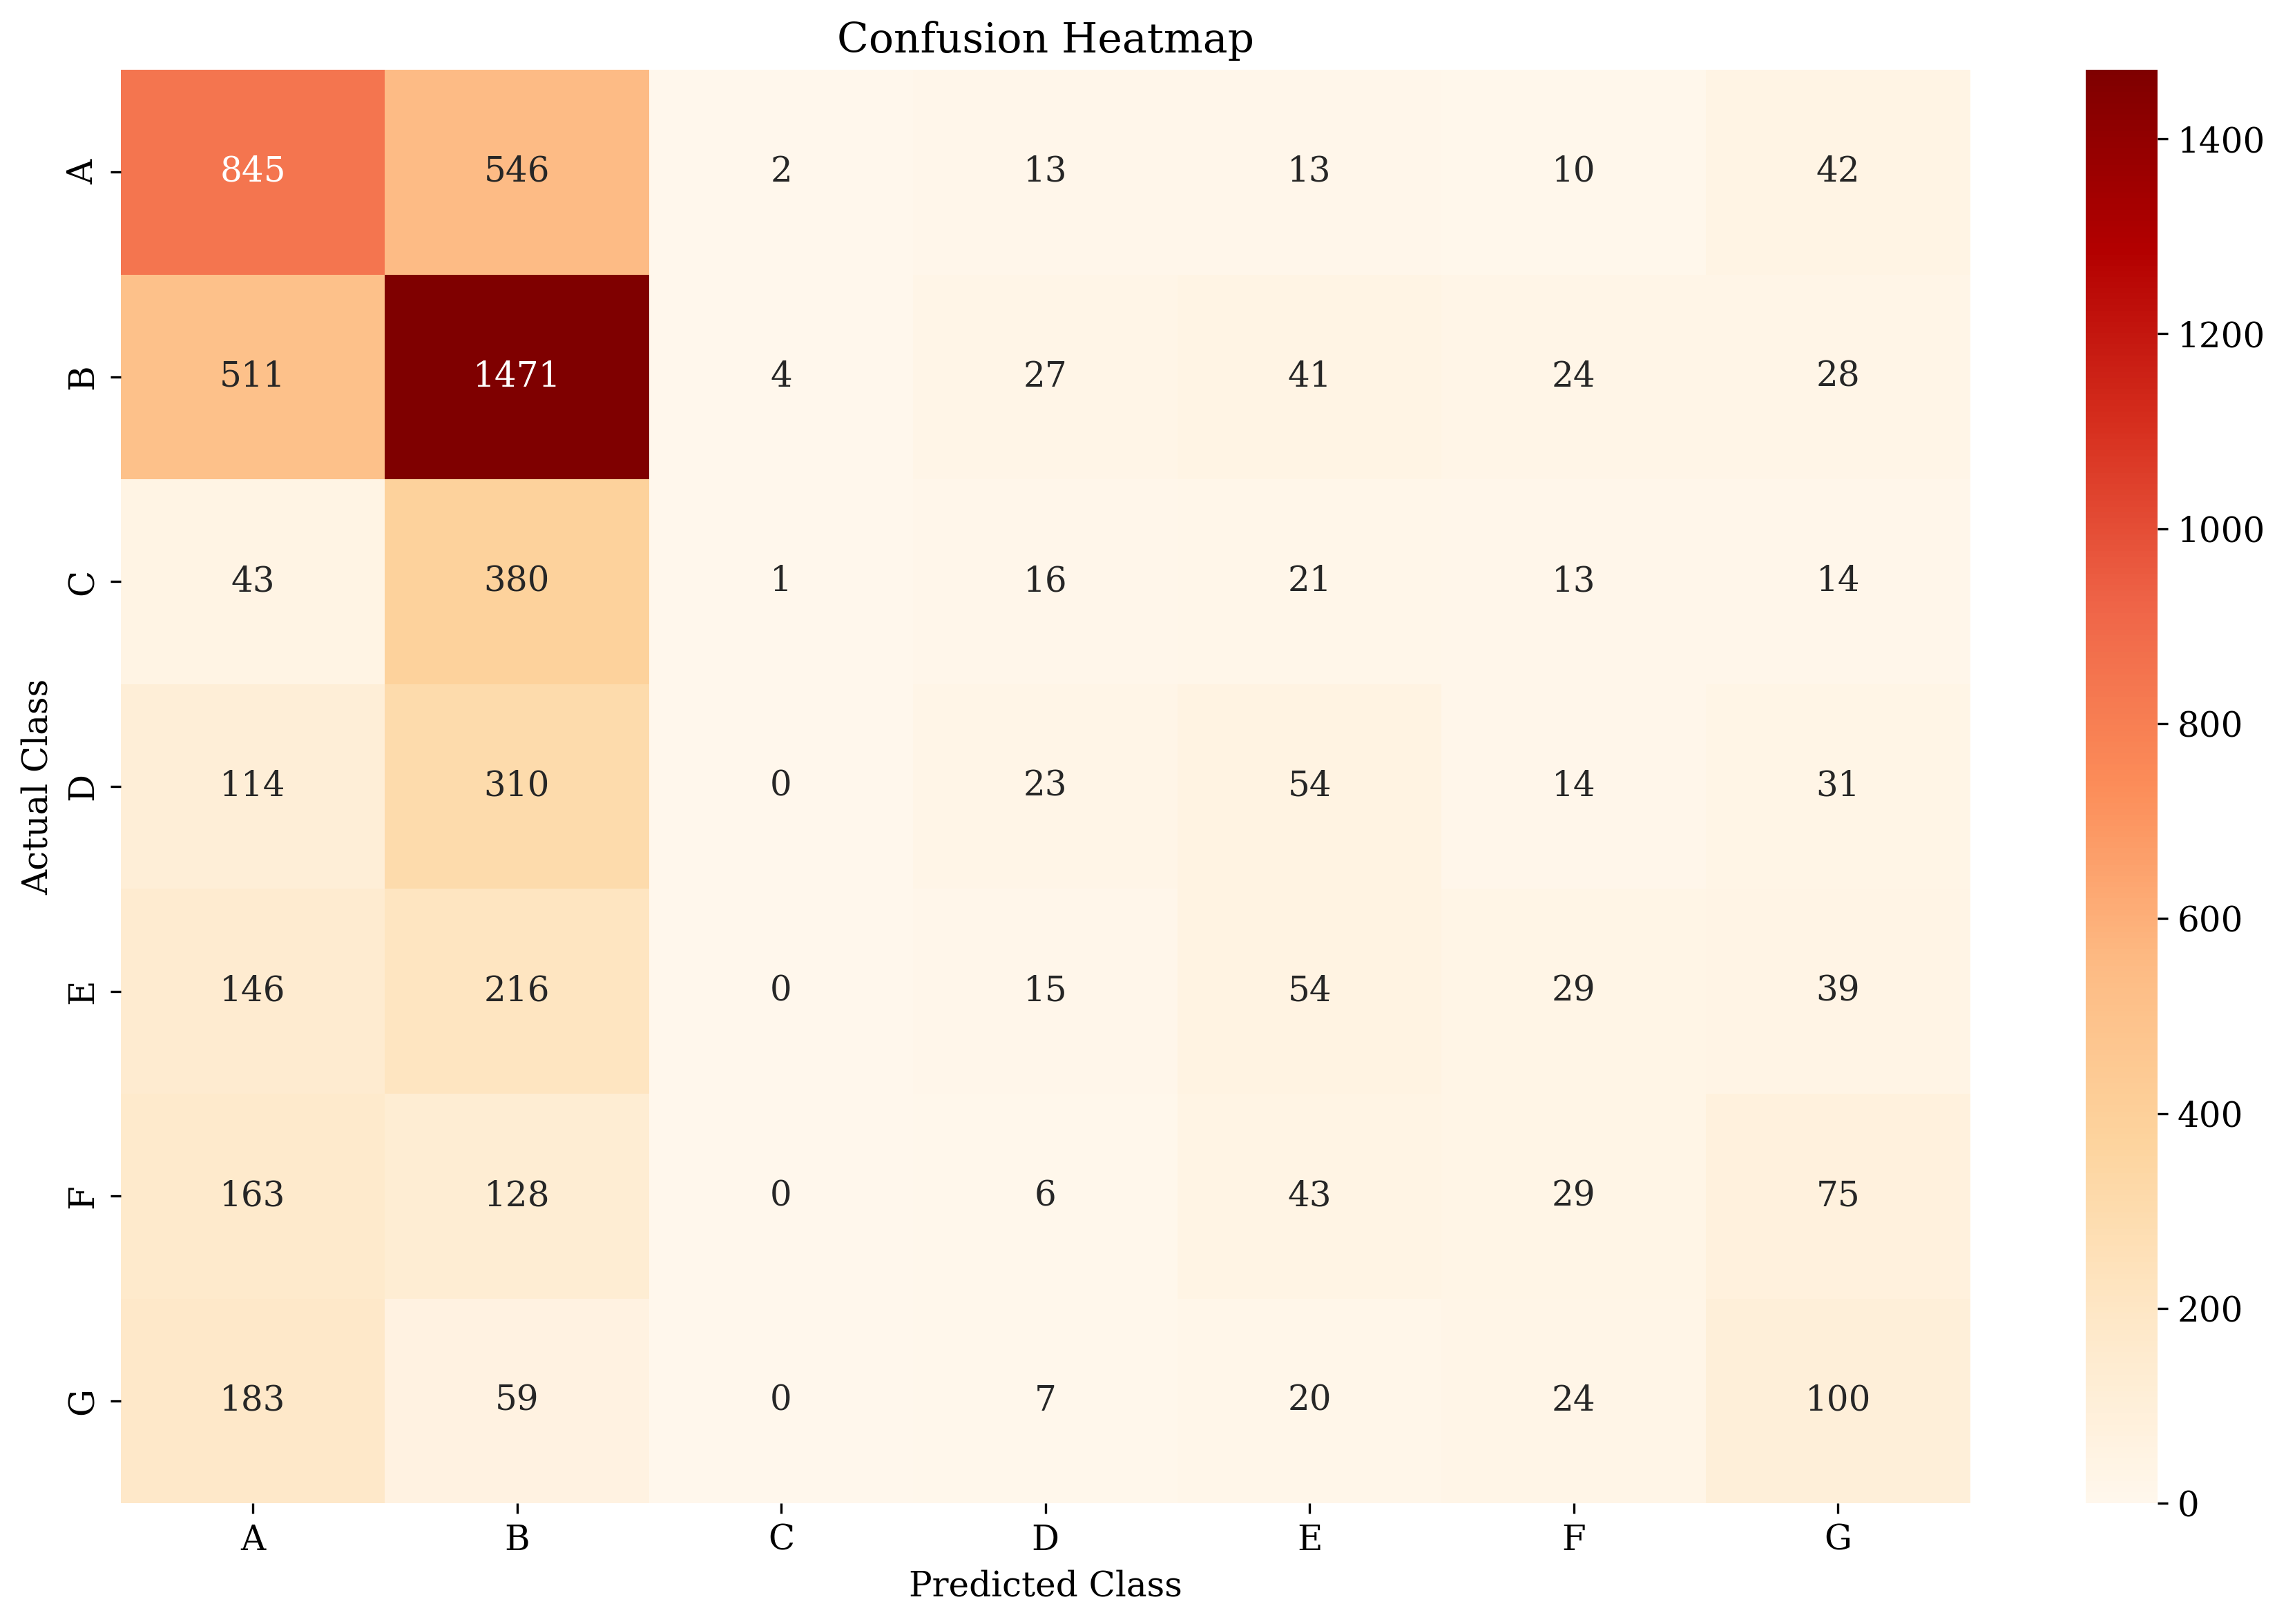

              precision    recall  f1-score   support

           A       0.42      0.57      0.49      1471
           B       0.47      0.70      0.56      2106
           C       0.14      0.00      0.00       488
           D       0.21      0.04      0.07       546
           E       0.22      0.11      0.14       499
           F       0.20      0.07      0.10       444
           G       0.30      0.25      0.28       393

    accuracy                           0.42      5947
   macro avg       0.28      0.25      0.24      5947
weighted avg       0.36      0.42      0.36      5947



In [20]:
model_utils.PlotConfusionMatrix(DT_model, X_test, y_test)

As we can see, the optimum depth - according to the validation scores - is a depth of 8. We see that after that point the model overfits and underperforms when classifying. We can further validate the optimum depth by using cross-validation, as this will reduce the data leakage that occurs when performing this hyperparameter optimisation. 

In [21]:
from sklearn.model_selection import cross_val_score

# Generate depths
depths = list(range(1, 51))

# Initialise list
cross_validation_scores = []

# Iteratively create models
for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    DT_model = DecisionTreeClassifier(max_depth=depth)
    cv_score = np.mean(cross_val_score(DT_model, X_rem, y_rem, cv = 2))
    cross_validation_scores.append(cv_score)

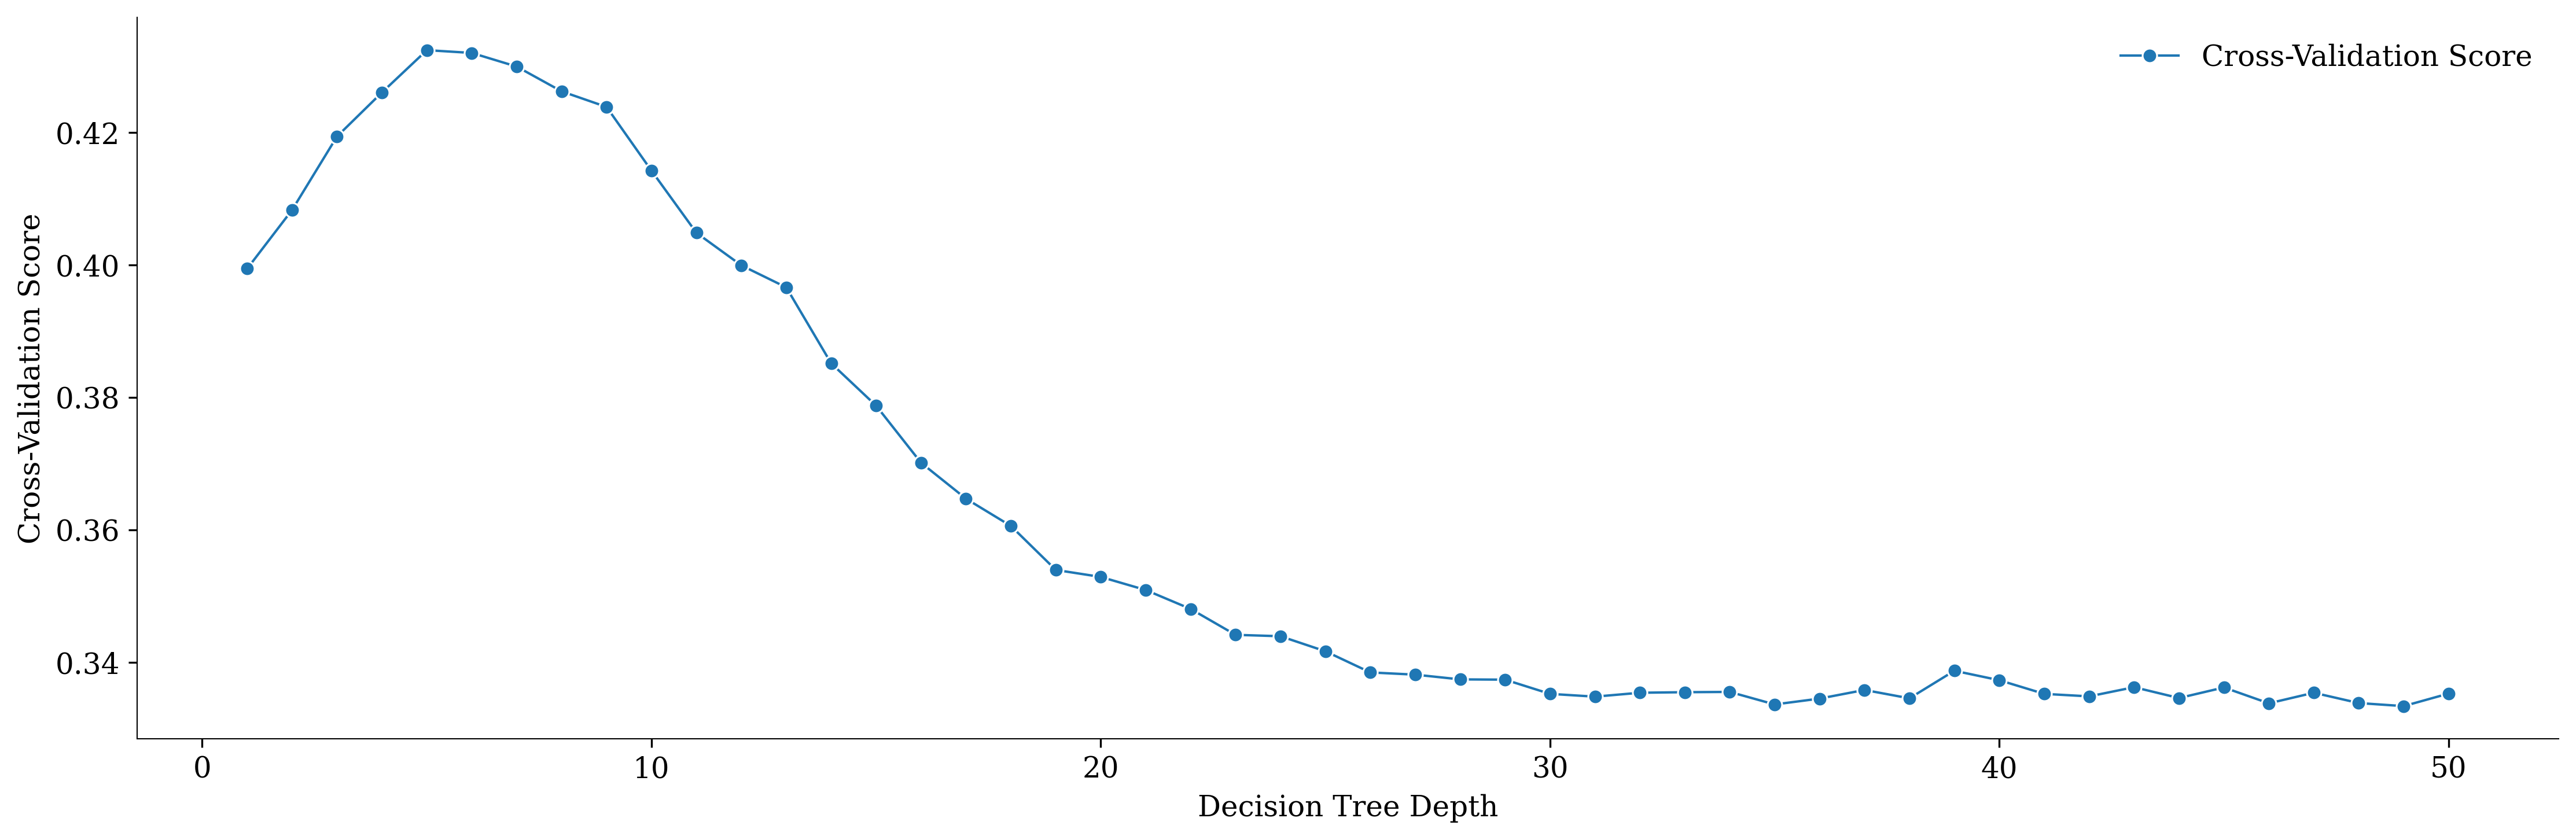

In [22]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=depths, y=cross_validation_scores, marker='o', label='Cross-Validation Score')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.show()

In [23]:
optimum_depth = depths[np.argmax(cross_validation_scores)]
print(f'The optimum depth for the decision tree model is {optimum_depth}')

The optimum depth for the decision tree model is 5


Having completed the cross validation we see that the optimum depth calculated was 5. Using this we can create a further model and calculate the accuracy of the model.

In [24]:
DT_model = DecisionTreeClassifier(max_depth=optimum_depth)
DT_model.fit(X_rem, y_rem)

print(f'The test accuracy of the model with a max depth of {optimum_depth} is: {DT_model.score(X_test, y_test):.2f}')

The test accuracy of the model with a max depth of 5 is: 0.42


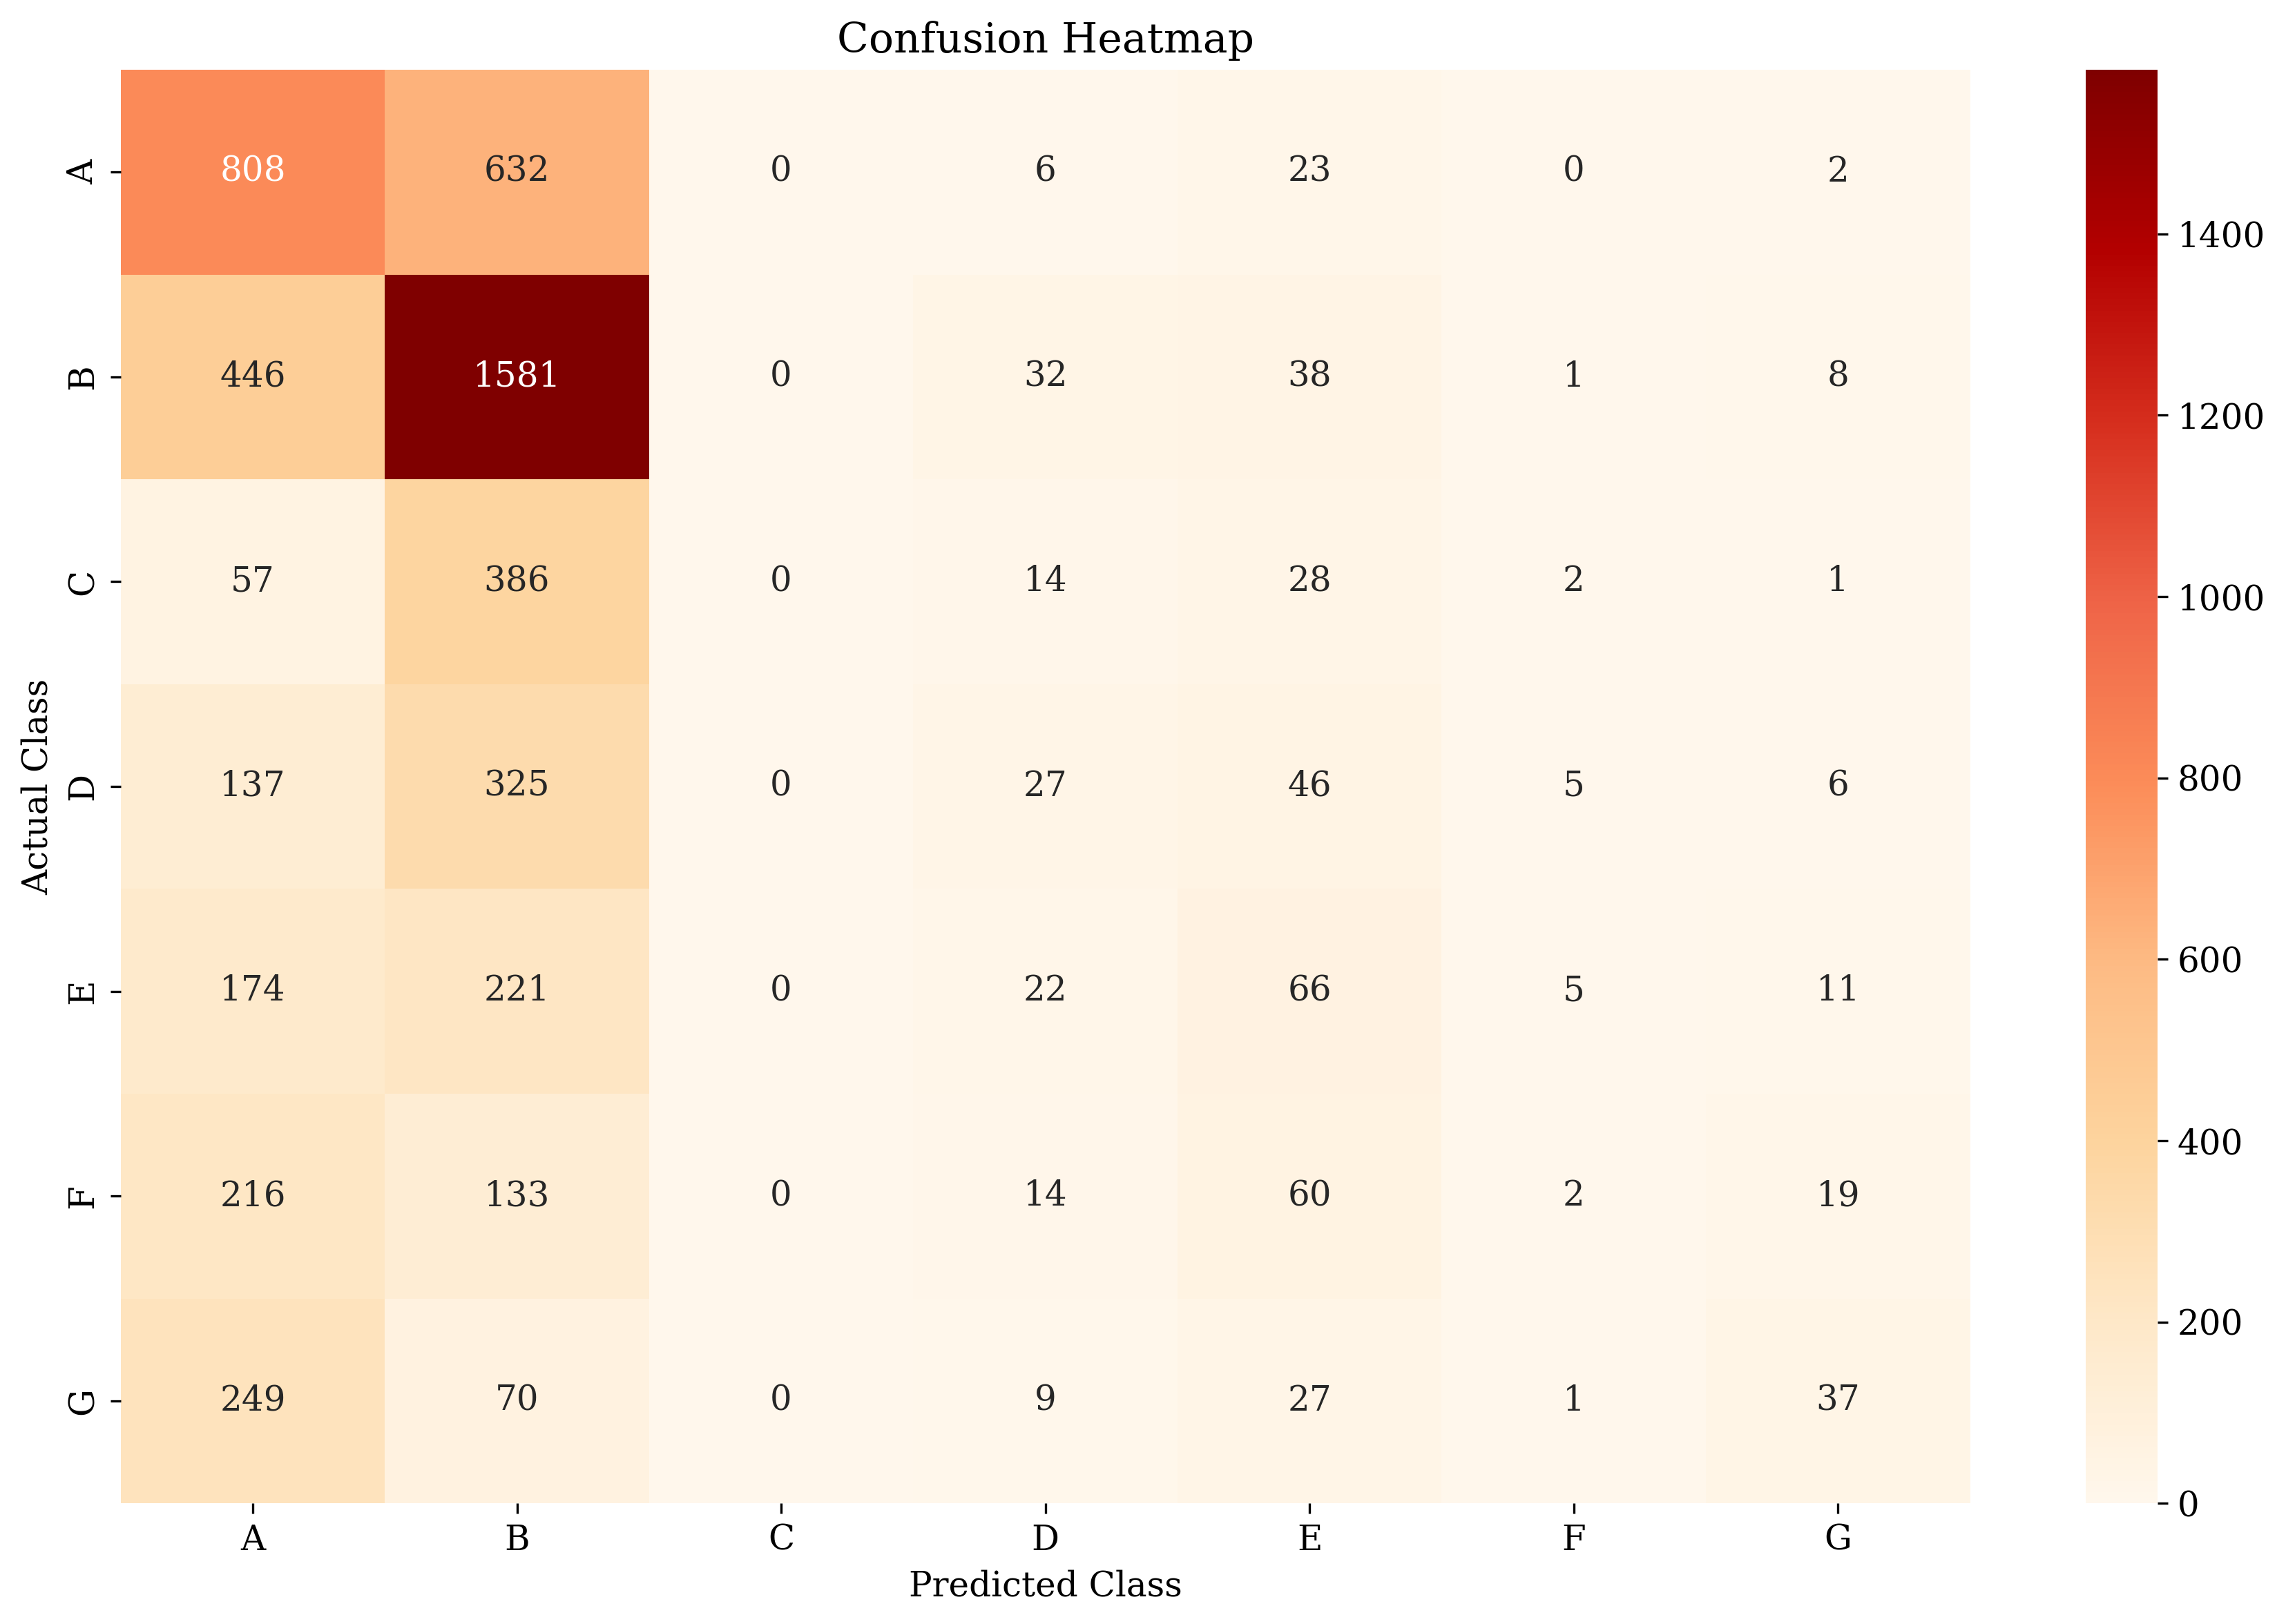

              precision    recall  f1-score   support

           A       0.39      0.55      0.45      1471
           B       0.47      0.75      0.58      2106
           C       0.00      0.00      0.00       488
           D       0.22      0.05      0.08       546
           E       0.23      0.13      0.17       499
           F       0.12      0.00      0.01       444
           G       0.44      0.09      0.16       393

    accuracy                           0.42      5947
   macro avg       0.27      0.23      0.21      5947
weighted avg       0.34      0.42      0.35      5947



In [25]:
model_utils.PlotConfusionMatrix(DT_model, X_test, y_test)

Interestingly, we see that when we use a depth of 5, the model becomes worse at identifying large wildfires, as the f1 scorse of many of these classes has decreased. Perhaps we can improve the model through a grid search.

<a id='gridsearch'></a>
### Hyperparameter Optimisation with Grid Search

The grid search that we are implementing at this stage is going to test multiple different hyperparameters for a decision tree model. The hyperparameters that we will be analysing are:
- Max depth: this will determine the depth of the tree. We will not be using an excessive amount of depths in the grid search as we have already found values in the range of 3 to 9.
- Critertion: this is the function used to measure the quality of a split.
- Splitter: this is the strategy used to choose the split at each node.
- Min samples leaf: this determines the minimum number of leaves that a node must have. By setting a maximum value, we are preventing a node from only having one lead - and consequently over-fitting.

We will additionally add a PCA into our pipeline to see whether we are able to improve the model through some sort of dimensionality reduction.

In [26]:
from tempfile import mkdtemp
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [{'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
               'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
               'model__criterion': ['gini', 'entropy'],
               'model__splitter': ['best', 'random'],
               'model__min_samples_leaf': list(range(2, 20, 2))}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


In [27]:
fittedgrid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__min_samples_leaf': 10,
 'model__splitter': 'best',
 'reduce_dim': None}

In [28]:
fittedgrid.best_estimator_.score(X_test, y_test)

0.42727425592735835

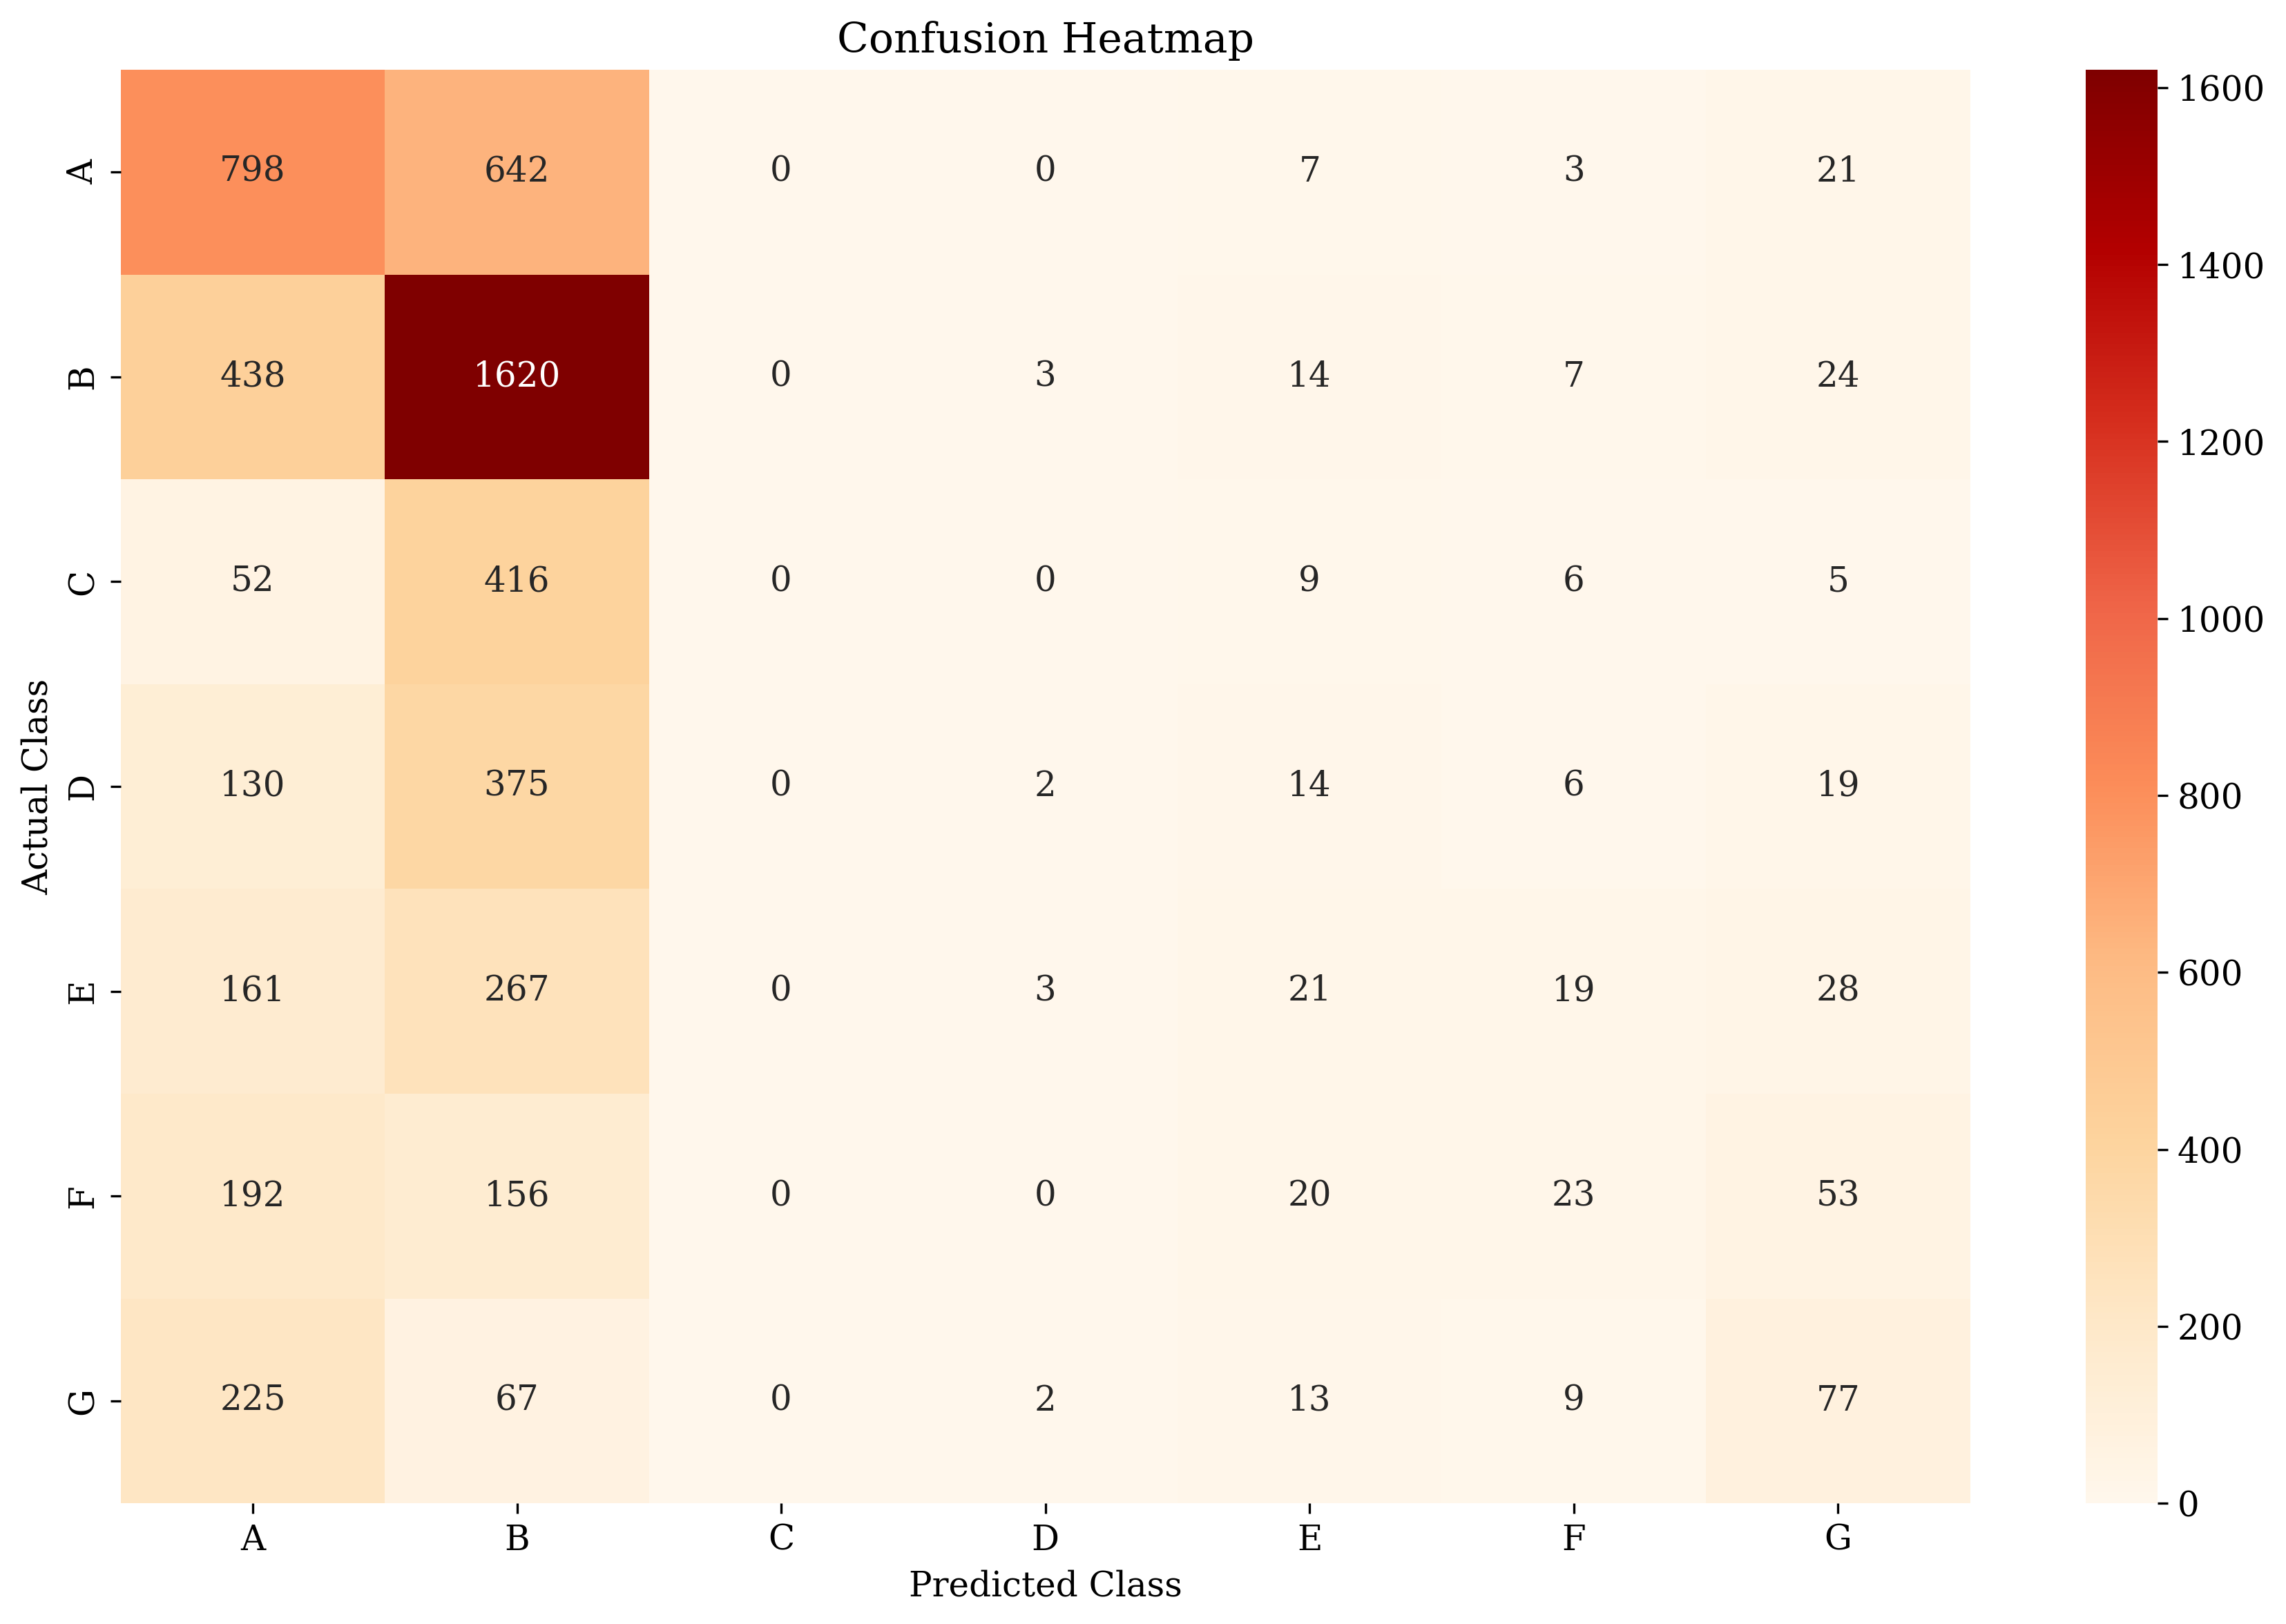

              precision    recall  f1-score   support

           A       0.40      0.54      0.46      1471
           B       0.46      0.77      0.57      2106
           C       0.00      0.00      0.00       488
           D       0.20      0.00      0.01       546
           E       0.21      0.04      0.07       499
           F       0.32      0.05      0.09       444
           G       0.34      0.20      0.25       393

    accuracy                           0.43      5947
   macro avg       0.28      0.23      0.21      5947
weighted avg       0.34      0.43      0.35      5947



In [29]:
model_utils.PlotConfusionMatrix(fittedgrid.best_estimator_, X_test, y_test)

Unfortunately, using grid search was unhelpful in creating a model that was able to improve upon the accuracy and f1 scores that we have already generated so far. It would be interesting to see which features were considered the most important by this model however.

In [30]:
best_model = fittedgrid.best_estimator_.get_params()["model"]

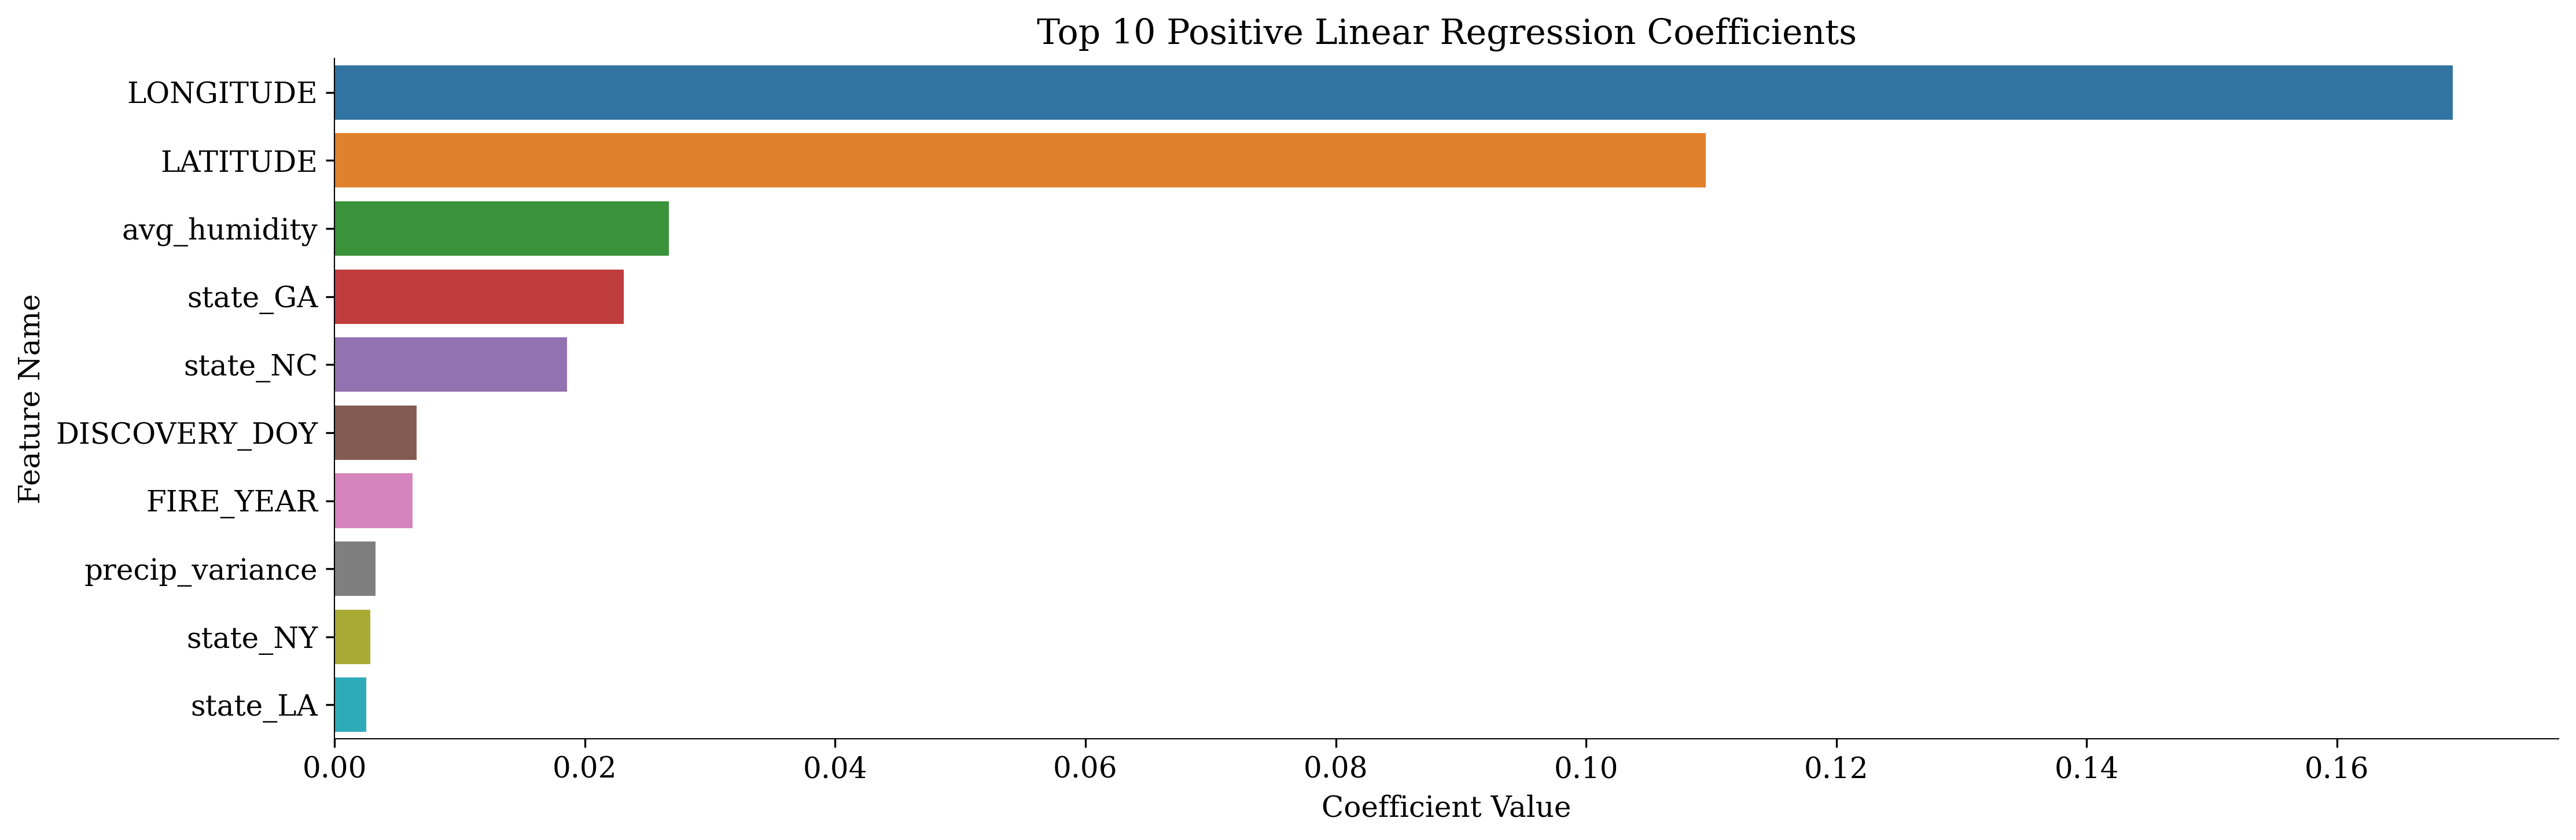

In [31]:
import dt_utils

dt_utils.plot_feature_importances(best_model, X)

We see that the decision tree classification returned similar important features as the linear regression model did. This is unsurprising considering that the models are trying to define the same boundaries. It is interesting to see how this also differs from other models, focusing a lot more on specific geographic location and some weather features, as well as different states in comparison to other models.

---
<a id='save'></a>
#### Saving the model

In [32]:
import pickle

pickle.dump(fittedgrid, open('models/dt_model.pkl', 'wb'))

<a id='load'></a>
#### Loading the model

In [33]:
# fittedgrid = pickle.load(open('models/dt_model.pkl', 'rb'))

---
<a id='conc'></a>
## Remarks on Decision Trees

The decision tree classifier so far has improved the accuracy of our models in comparison to the logistic regression models that we built in previous notebooks. This is largely due to the difference in calculating feature importance; decision trees are able to define non-linear boundaries meaning that in instances where data is not linearly separable - as is the case in our project - a decision tree is able to create a better, more accurate, model. That being said, our model is still not very good at predicting fire size classes. Fortunately, we are able to use ensemble, and more specifically, boosting methods - a machine learning technique that combines the predictions of multiple models to create a more accurate prediction. 